# Perform time series forecasting using XGBoost

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

from joblib import dump
from joblib import load

In [111]:
df = pd.read_csv("./data/Mastercard_stock_history.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


Once again, we try to forecast the close price using previous date features, as well as generating new features for our model to predict the close price

In [112]:
# convert Date into datetime, and set the date as the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
# set date as the index
df.set_index('Date', inplace=True)

df = df.asfreq("D")
df = df.interpolate() # interpolate data to remove NaN values

## Create new features for the model

We will create features for:

1. month
2. day of the week
3. moving average
4. moving standard deviation
5. previous days' lagged close prices
6. open price
7. quarter of the year
8. Relative Strength Indicator

In [113]:
df['month'] = df.index.month
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month
Date,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5


In [114]:
df['day'] = df.index.day_of_week
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day
Date,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0


In [115]:
df['quarter'] = df.index.quarter
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter
Date,,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3,2
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4,2
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2


In [116]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)

df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2
Date,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793


In [117]:
# create RSI indicator
df['change'] = df['Close'].diff()
df['change'] = df['change'].shift(1) # lag the change column by 1 time step

df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0)
df['loss'] = df['change'].apply(lambda x: -x if x < 0 else 0)



df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2,change,gain,loss
Date,,,,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217,NaN,0.0,0.000000
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680,NaN,0.0,0.000000
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051,-0.021629,0.0,0.021629
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422,-0.021629,0.0,0.021629
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793,-0.021629,0.0,0.021629


In [118]:
# add RSI
df['avg_gain'] = df['gain'].rolling(window = 30, min_periods = 1).mean()
df['avg_loss'] = df['loss'].rolling(window = 30, min_periods = 1).mean()

df['RSI'] = 100 - (100 / (1 + (df["avg_gain"] / df["avg_loss"])))
# add ARBR with n = 30
sum_high_open_diff = (df["High"] - df["Open"]).rolling(window=6, min_periods=1).sum()
sum_open_low_diff = (df["Open"] - df["Low"]).rolling(window=6, min_periods=1).sum()
df['AR'] = 100 * (sum_high_open_diff / sum_open_low_diff)

shifted_close_1 = df["Close"].shift(1)
max_high_close_diff = (df['High'] - shifted_close_1).apply(lambda v: max(0, v))
max_close_low_diff = (shifted_close_1 - df['Low']).apply(lambda v: max(0, v))
df['BR'] = 100 * (max_high_close_diff.rolling(window=6, min_periods=1).sum()
                  / max_close_low_diff.rolling(window=6, min_periods=1).sum())
# robust scaling on these features: rmse = 7.92


df[:7]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2,change,gain,loss,avg_gain,avg_loss,RSI,AR,BR
Date,,,,,,,,,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217,NaN,0.000000,0.000000,0.000000,0.000000,NaN,15.304803,NaN
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680,NaN,0.000000,0.000000,0.000000,0.000000,NaN,12.882599,95.481925
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051,-0.021629,0.000000,0.021629,0.000000,0.007210,0.000000,10.440726,84.110692
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422,-0.021629,0.000000,0.021629,0.000000,0.010814,0.000000,7.978942,73.461091
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793,-0.021629,0.000000,0.021629,0.000000,0.012977,0.000000,19.743606,108.332421
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000.0,0.0,0.0,6,3,2,4.180608,4.093164,0.087444,0.087444,0.000000,0.014574,0.010814,57.404057,56.471040,187.435339
2006-06-02,4.511782,4.530387,4.352707,4.371312,37253000.0,0.0,0.0,6,4,2,4.419686,4.180608,0.239078,0.239078,0.000000,0.046646,0.009270,83.422287,58.049489,184.011592


In [119]:
# create lag-1 30 day rolling mean and standard deviations
df['MA'] = df["lag_1"].rolling(30).mean()
df['M_STD'] = df["lag_1"].rolling(30).std()

df = df.dropna() # remove NaNs after rolling functions have been applied

In [120]:
columns_to_keep = ["Open", "Volume", "Close", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD", "RSI", "AR", "BR"] # ignore RSI, since it makes predictions worse
df1 = df[columns_to_keep]
df1.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD,RSI,AR,BR
Date,,,,,,,,,,,,,
2006-06-25,4.368834,9.580667e+06,4.401703,6,6,2,4.384648,4.367593,4.296050,0.142795,57.101174,198.443901,409.166142
2006-06-26,4.367594,8.565000e+06,4.418758,6,0,2,4.401703,4.384648,4.303451,0.142308,57.554892,296.153824,376.928943
2006-06-27,4.418758,9.826000e+06,4.401083,6,1,2,4.418758,4.401703,4.312141,0.141078,57.999114,198.048682,262.500710
2006-06-28,4.358291,8.756000e+06,4.368524,6,2,2,4.401083,4.418758,4.320963,0.137951,58.140164,215.957275,127.473118
2006-06-29,4.367592,1.447000e+07,4.465270,6,3,2,4.368524,4.401083,4.329421,0.132547,57.751885,242.045056,119.706894


## Standardize the data

In [105]:
scaler = StandardScaler()
robust_scaler = RobustScaler()
cols_to_standardize = ['Open', "Volume", "lag_1", "lag_2", "MA", "M_STD"]
df1[cols_to_standardize] = scaler.fit_transform(df1[cols_to_standardize])
cols_to_scale = ['AR', 'BR', "RSI"]
df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])
df1.head()

C:\Users\proki\AppData\Local\Temp\ipykernel_25924\4263667423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[cols_to_standardize] = scaler.fit_transform(df1[cols_to_standardize])
C:\Users\proki\AppData\Local\Temp\ipykernel_25924\4263667423.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])


,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD,RSI,AR,BR
Date,,,,,,,,,,,,,
2006-08-22,-0.954496,-0.135716,5.137852,8,1,3,-0.954700,-0.954724,-0.955909,-0.639954,1.894837,0.578311,-0.380711
2006-08-23,-0.953375,-0.092897,5.079244,8,2,3,-0.953850,-0.954488,-0.955611,-0.641073,2.026869,0.670347,-0.210350
2006-08-24,-0.953883,-0.409869,5.176922,8,3,3,-0.954402,-0.953637,-0.955329,-0.643796,1.815182,1.156197,0.318524
2006-08-25,-0.953139,-0.245920,5.116456,8,4,3,-0.953482,-0.954190,-0.955048,-0.644767,1.812199,0.704486,0.227222
2006-08-26,-0.953401,-0.335768,5.117076,8,5,3,-0.954051,-0.953269,-0.954803,-0.646313,1.505008,0.306608,0.556136


## Modelling

In [106]:
# split data into last 20 days to predict as test data
df_train = df1.iloc[:-100]
df_test = df1.iloc[-100:]

X_train = df_train[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD", "RSI", "AR", "BR"]][:-1]
y_train = df_train[["Close"]].shift(-1)[:-1]
X_test = df_test[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD", "RSI", "AR", "BR"]][:-1]
y_test = df_test[["Close"]].shift(-1)[:-1]

In [107]:
model = XGBRegressor(objective = "reg:squarederror")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [108]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Root mean squared error is: {np.sqrt(mse) : .2f}")

Root mean squared error is:  6.96


In [109]:
y_pred

array([375.86234, 375.7037 , 375.47977, 375.57016, 380.05212, 373.93204,
       376.60703, 375.5703 , 375.79877, 363.28372, 387.4374 , 385.55743,
       383.9206 , 380.15186, 367.34467, 356.31415, 362.82065, 373.28082,
       375.556  , 380.9139 , 382.46518, 383.16266, 382.29718, 377.9964 ,
       380.7096 , 380.01044, 376.69574, 375.2584 , 376.43588, 375.68073,
       361.07495, 367.84824, 369.78616, 369.8751 , 369.8584 , 372.65665,
       367.30804, 365.5269 , 366.4798 , 359.13214, 363.13287, 353.3415 ,
       353.15558, 353.54532, 353.86313, 355.97577, 357.5237 , 357.12057,
       352.22403, 361.49887, 358.35156, 359.74496, 360.1359 , 356.97903,
       352.02887, 359.87408, 349.87677, 347.3266 , 348.09723, 347.92294,
       341.72366, 345.00272, 345.868  , 346.51678, 343.375  , 346.48453,
       353.0611 , 353.6898 , 347.28638, 345.20807, 343.97382, 340.03018,
       344.70184, 339.35608, 340.851  , 343.62662, 342.60114, 330.35165,
       333.2405 , 330.767  , 332.75647, 346.8298 , 

Plot the predicted and actual data

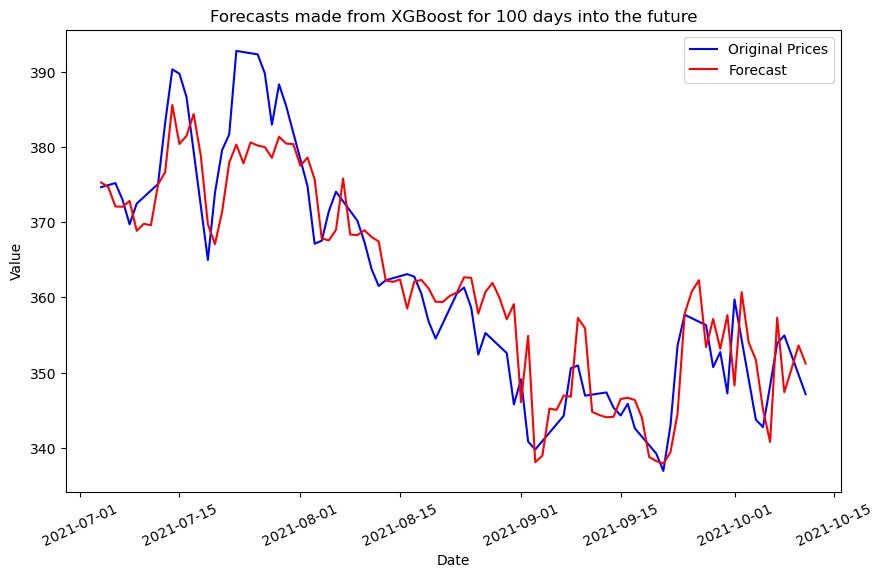

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from XGBoost for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

We can see that the XGBoost model is much better at predicting the time series compared to ARIMA in the modelling notebook, as we get a much lower MSE

## Save the model

In [177]:
dump(model, "./models/XGBRegressor.pkl")

['./models/XGBRegressor.pkl']

In [178]:
# test loading of model
test_model = load("./models/XGBRegressor.pkl")

In [179]:
test_model.predict(X_test)

array([373.00775, 370.86652, 370.46085, 371.59366, 373.08603, 371.47424,
       369.87262, 369.3079 , 373.592  , 377.5758 , 383.72238, 380.49557,
       380.03085, 381.39902, 380.64047, 371.60797, 370.0987 , 372.45883,
       376.85458, 380.50473, 377.89795, 379.67258, 381.13293, 378.59415,
       379.4101 , 382.38937, 380.23474, 380.24216, 377.9546 , 377.6796 ,
       375.13248, 365.4521 , 368.9594 , 370.2295 , 376.05276, 370.4649 ,
       369.26035, 366.56726, 366.36337, 366.72595, 363.74054, 363.47125,
       363.64624, 360.16446, 361.9089 , 362.17783, 363.45273, 356.8581 ,
       355.82767, 356.9677 , 361.89667, 362.0523 , 363.42996, 356.67456,
       360.07156, 360.0048 , 358.65768, 356.69467, 355.033  , 344.33774,
       352.974  , 336.437  , 337.99966, 341.67633, 345.20483, 345.07278,
       346.86435, 355.3822 , 355.28787, 343.69843, 342.9181 , 341.78302,
       341.1998 , 346.80383, 344.35577, 343.60074, 339.2947 , 338.02658,
       337.95087, 338.62323, 339.33975, 341.33823, 

Our model can be saved and loaded successfully.